# Optimization of $Y(A,TKE)$ for Cf-252 with Hierarchical parameterization

In [2]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
from scipy.stats import chisquare
%matplotlib inline

In [3]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [4]:
def rearrange(YATKE):
    return np.transpose(np.asarray(YATKE).reshape(150, 200))

def YATKEplot(YATKE):
    fig, axes = pl.subplots(1, 1, figsize=(15, 10))
    c1 = plt.imshow(YATKE, extent=[51,200, 100,299], origin="lower")
    plt.xlabel('A')
    plt.ylabel('TKE')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.xlim(80,170)
    plt.ylim(150,225)
    
def gauss(x,mu,sigma,w):
    return w/sigma/np.sqrt(2*np.pi)*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,w1,mu2,sigma2,w2):
    return gauss(x,mu1,sigma1,w1)+gauss(x,mu2,sigma2,w2)

In [5]:
def get_all_data():
    #get yield data for Cf 252 *************************************************************************************
    f=open(os.path.join(os.getcwd(),'yieldsATKE.Cf252.sf.dat3'),"r")
    lines=f.readlines()
    YATKE_data=[]
    for x in lines:
        x = x.split()
        if len(x) != 0:
            YATKE_data.append(x[2])
    f.close()

    #convert from strings to ints
    YATKE_data = np.asarray(list(map(float, YATKE_data)))
    print('DATA ACQUIRED')
    return YATKE_data

In [6]:
# model according to Brosa

import warnings
warnings.filterwarnings("error")

def YATKE(tuple_in, h0,h1,h2, dmin0,dmin1,dmin2, dmax0,dmax1,dmax2,
         ddec0,ddec1,ddec2, Abar0,Abar1,Abar2, sigA0,sigA1,sigA2):
    
    #unpack the tuple
    A, TKE = tuple_in
    
    # pack the arrays - order of the modes is: SL, S1, S2
    # 30 total parameters, 5 modes x 6 parameters
    h           = np.array([h0,h1,h2])
    dmin        = np.array([dmin0, dmin1, dmin2])
    dmax        = np.array([dmax0, dmax1, dmax2]) 
    ddec        = np.array([ddec0, ddec1, ddec2])
    Abar        = np.array([Abar0, Abar1, Abar2])
    sigA        = np.array([sigA0, sigA1, sigA2])
    
    
    # define YATKE
    Y = [] # yield list that will be returned
    
    # sub "cn" refers to 'compound nucleus' - in this case the 252 pre-fission nucleus
    A_cn = 252.
    Z_cn = 98.
    
    e2 = 1.4399643929 # MeV fm
    #see http://www.vanderbilt.edu/AnS/physics/volker/p340a/section_1/1.3_notes_nucl_units.pdf
                        # e^2 = alpha * hbar * c
    # i index over A - turn into columns when rearranged
    for i in range(len(A)):
        # j index over TKE - rows of rearranged data
        for j in range(len(TKE)):
            Yij = 0.

            # k index over modes
            for k in range(len(h)):
                
                T = (Z_cn / A_cn) ** 2 * (A[i] * (A_cn - A[i]) * e2) / TKE[j] - dmin[k] # fm
                
                if (T <= 0.0):
                    Yij += 0.
                else:
                    try:
                        YTKE = (200/TKE[j])** 2 * h[k] * np.exp(2*(dmax[k]-dmin[k])/ddec[k] - 
                                                       T/ddec[k] - (dmax[k] - dmin[k])**2/T/ddec[k])
                    except RuntimeWarning:
                        print('dmax is: ',dmax[k],'\n', 'dmin is: ',dmin[k],'\n', 'ddec is: ',ddec[k],'\n', 'T is: ',T,'\n')
                
                    #remember that the sL mode is NOT bimodal
                    if (k != 0):
                    
                        YA = 1/np.sqrt(8*np.pi*sigA[k]**2) * \
                        (np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2)) + \
                         np.exp(-(A[i]-A_cn+Abar[k])**2/(2*sigA[k]**2)))
                        
                    else:
                        YA = 1/np.sqrt(2*np.pi*sigA[k]**2) * \
                        np.exp(-(A[i]-Abar[k])**2/(2*sigA[k]**2))

                    Yij += YTKE * YA
                
            Y.append(Yij)
    
    return np.asarray(Y)

In [7]:
# initial fit to get parameters for initial guesses

hl, h1, h2 = 2.02e4, 1.47e5, 8.7e5
dminl, dmin1, dmin2 = 16.8, 10.9, 13.7
dmaxl, dmax1, dmax2 = 18.7, 17.1, 17.9
ddecl, ddec1, ddec2 = 0.521, 0.125, 0.270
Abarl, Abar1, Abar2 = 126.9, 134.9, 142.5
sigAl, sigA1, sigA2 = 11.62, 3.16,  4.99

# define A
A = np.linspace(51,200,150)

# define TKE
TKE = np.linspace(100,299,200)

YATKE_prior = YATKE((A,TKE), hl, h1, h2, dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, 
                   ddecl, ddec1, ddec2, Abarl, Abar1, Abar2, sigAl, sigA1, sigA2)

DATA ACQUIRED


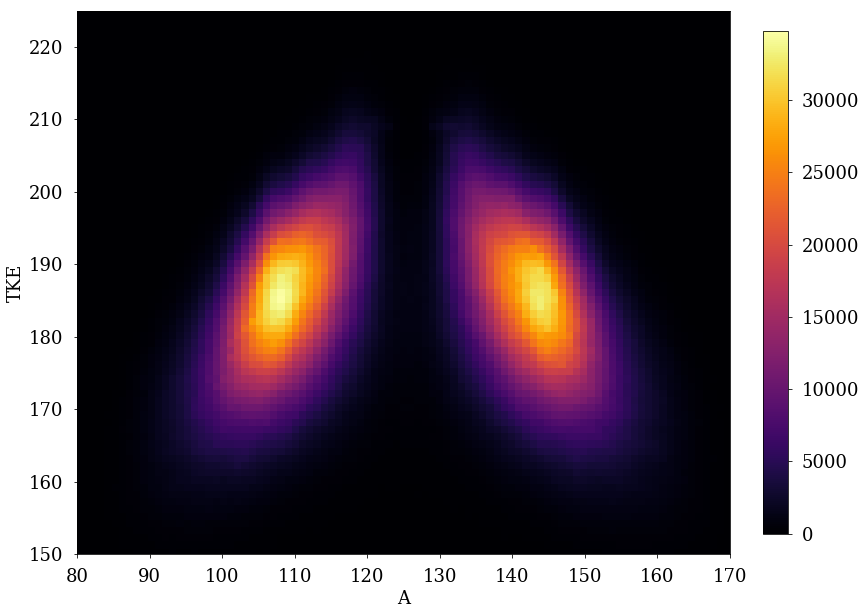

In [8]:
YATKEplot(rearrange(get_all_data()))

In [9]:
# create functions for projection onto 1d for Y(A) and Y(TKE)

def YAproj(YATKE, A = np.linspace(51,200,150)):
    
    YA = np.zeros(len(A))
    for i in range(len(A)):
        YA[i]    = sum(YATKE[:,i])
        
    # normalize to pdf 
    total = sum(YA)
    YA = np.asarray([float(i)/total for i in YA])
    return YA

def YTKEproj(YATKE, A = np.linspace(100,299,200)):
    
    YTKE = np.zeros(len(TKE))
    for i in range(len(TKE)):
        YTKE[i]    = sum(YATKE[i,:])
        
    # normalize to pdf 
    total = sum(YTKE)
    YTKE = np.asarray([float(i)/total for i in YTKE])   
    return YTKE

In [10]:
def chi2(Observed, Expected):
    chi2 = np.zeros(len(Observed))
    for i in range(len(Observed)):
        chi2[i] = (Observed[i] - Expected[i])**2 / Expected[i]
    return sum(chi2)

In [11]:
# Now we move on to optimization 
# method to use is scipy.optimize.minimize
# we will be minimizing the chisquare between the data and the model

# chisquare_YATKE refers to a model to get chisquared for full model

YATKE_data  = get_all_data()

def chisquare_YATKE(tup_in):
    
    h0,h1,h2, dmin0,dmin1,dmin2, dmax0,dmax1,dmax2,\
         ddec0,ddec1,ddec2, Abar0,Abar1,Abar2, sigA0,sigA1,sigA2 = tup_in

    YATKE_model = YATKE((A,TKE), h0,h1,h2, dmin0,dmin1,dmin2, dmax0,dmax1,dmax2,
         ddec0,ddec1,ddec2, Abar0,Abar1,Abar2, sigA0,sigA1,sigA2)

    return chi2(YATKE_model[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])

DATA ACQUIRED


In [12]:
hl, h1, h2 = 2.02e4, 1.47e5, 8.7e5
dminl, dmin1, dmin2 = 16.8, 10.9, 13.7
dmaxl, dmax1, dmax2 = 18.7, 17.1, 17.9
ddecl, ddec1, ddec2 = 0.521, 0.125, 0.270
Abarl, Abar1, Abar2 = 126.9, 134.9, 142.5
sigAl, sigA1, sigA2 = 11.62, 3.16,  4.99

x0 = np.array([hl, h1, h2,dminl, dmin1, dmin2, dmaxl, dmax1, dmax2, ddecl, ddec1, ddec2, 
                  Abarl, Abar1, Abar2, sigAl, sigA1, sigA2 ])

bnds = ((0.,None),(0.,None), (0.,None), 
       (0.,None),(0.,None), (0.,None),
       (0.,None),(0.,None), (0.,None),
       (0.,None),(0.,None), (0.,None),
       (0.,None),(0.,None), (0.,None),
       (0.,None),(0.,None), (0.,None))

result =  opt.minimize(chisquare_YATKE, x0,bounds=bnds, options={'disp': True, 'maxiter':30})


In [13]:
print(result)
print(x0 )

      fun: 1032405.7957266469
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.45058060e+00,   3.14321369e-01,   2.51457095e+00,
        -2.34991079e+04,   2.37192726e+03,  -2.51425197e+04,
         4.17208765e+04,  -1.90554420e+04,   5.75501472e+03,
         9.51532624e+04,  -2.49944860e+03,   3.42646148e+04,
        -4.46826452e+03,  -4.06088307e+04,   3.88416927e+04,
        -1.53742498e+04,  -4.15706309e+04,   5.04560885e+04])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 722
      nit: 31
   status: 1
  success: False
        x: array([  2.02000000e+04,   1.47000000e+05,   8.70000000e+05,
         1.68222595e+01,   1.08928649e+01,   1.40695174e+01,
         1.88918116e+01,   1.72329367e+01,   1.82917516e+01,
         8.64536930e-01,   9.59530107e-02,   3.31185862e-01,
         1.26921719e+02,   1.35459943e+02,   1.43932846e+02,
         1.16938724e+01,   3.25757609e+00,   6.13119367e+00])
[  2.02000000e+04   1.47000000e+05   8.

In [14]:
# now that overall result is done, we do some fine tuning, mode by mode
def YA_s2(tup_in):
    h2, Abar2, sigA2 = tup_in
    hl, h1 = 2.02e4, 1.47e5
    Abarl, Abar1 = 1.26921577e+02, 1.35453735e+02
    sigAl, sigA1 = 1.16934417e+01, 3.25441298e+00,
    A_cn = 252.
    YA = np.zeros(len(A))
    for i in range(len(A)):
        YA[i] += bimodal(A[i],Abar2,sigA2,h2/2.,(A_cn - Abar2),sigA2,h2/2.)
        YA[i] += bimodal(A[i],Abar1,sigA1,h1/2.,(A_cn - Abar1),sigA1,h1/2.)
        YA[i] += gauss(A[i],Abarl,sigAl,hl)
        
    # normalize to pdf 
    total = sum(YA)
    YA = np.asarray([float(i)/total for i in YA])
    
    return YA

YATKE_data   = get_all_data()
def chi2YAs2(tup_in):

    YA_data      = YAproj(rearrange(YATKE_data))
    YA_model     = YA_s2(tup_in)
    return  chi2(YA_model[YA_data != 0.], YA_data[YA_data != 0.])

res_ovrll = result.x
s2g = np.array([res_ovrll[2], res_ovrll[14], res_ovrll[17]])
print(s2g)
bnds = ((0.,None),(0.,None), (0.,None))
results2 =  opt.minimize(chi2YAs2, s2g, bounds=bnds, options={'disp': True})
print(results2)

DATA ACQUIRED
[  8.70000000e+05   1.43932846e+02   6.13119367e+00]
      fun: 0.016885622098945858
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.56125113e-08,  -1.74860126e-07,   2.51187959e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 4
   status: 0
  success: True
        x: array([  8.70000000e+05,   1.44542941e+02,   6.11049855e+00])


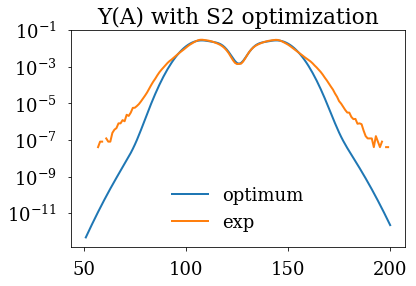

In [15]:
YA_data = YAproj(rearrange(YATKE_data))


plt.semilogy(A,YA_s2(results2.x), label = 'optimum')
plt.semilogy(A,YA_data, label = 'exp')
plt.title('Y(A) with S2 optimization')
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

In [16]:
# now that overall result is done, we do some fine tuning, mode by mode
def YA_s1(tup_in):
    h1, Abar1, sigA1 = tup_in
    hl, h2 = 2.02e4, 8.70000000e+05
    Abarl, Abar2 = 1.26921577e+02, 1.44542941e+02
    sigAl, sigA2 = 1.16934417e+01, 6.11049848e+00
    A_cn = 252.
    YA = np.zeros(len(A))
    for i in range(len(A)):
        YA[i] += bimodal(A[i],Abar2,sigA2,h2/2.,(A_cn - Abar2),sigA2,h2/2.)
        YA[i] += bimodal(A[i],Abar1,sigA1,h1/2.,(A_cn - Abar1),sigA1,h1/2.)
        YA[i] += gauss(A[i],Abarl,sigAl,hl)
        
    # normalize to pdf 
    total = sum(YA)
    YA = np.asarray([float(i)/total for i in YA])
    
    return YA

YATKE_data   = get_all_data()
YA_data      = YAproj(rearrange(YATKE_data))

def chi2YAs1(tup_in):

    YA_model     = YA_s1(tup_in)
    return  chi2(YA_model[YA_data != 0.], YA_data[YA_data != 0.])

res_ovrll = result.x
s1g = np.array([res_ovrll[1], res_ovrll[13], res_ovrll[16]])
print(s1g)
bnds = ((0.,None),(0.,None), (0.,None))
results1 =  opt.minimize(chi2YAs1, s1g, bounds=bnds, options={'disp': True})
print(results1)

DATA ACQUIRED
[  1.47000000e+05   1.35459943e+02   3.25757609e+00]
      fun: 0.014964823092572303
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.76941795e-08,   4.95090080e-06,  -5.64721880e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 5
   status: 0
  success: True
        x: array([  1.47000000e+05,   1.36328357e+02,   3.69578512e+00])


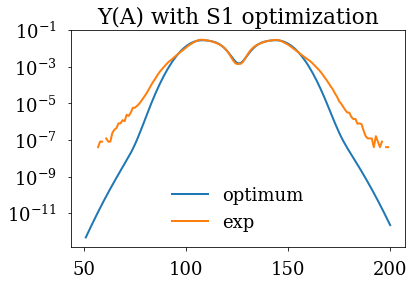

In [17]:

plt.semilogy(A,YA_s1(results1.x), label = 'optimum')
plt.semilogy(A,YA_data, label = 'exp')
plt.title('Y(A) with S1 optimization')
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

In [18]:
# now that overall result is done, we do some fine tuning, mode by mode
def YA_sl(tup_in):
    hl, Abarl, sigAl = tup_in
    h1, h2 = 1.47000000e+05, 8.70000000e+05
    Abar1, Abar2 = 1.36328441e+02, 1.44542941e+02
    sigA1, sigA2 = 3.69590546e+00, 6.11049848e+00
    A_cn = 252.
    YA = np.zeros(len(A))
    for i in range(len(A)):
        YA[i] += bimodal(A[i],Abar2,sigA2,h2/2.,(A_cn - Abar2),sigA2,h2/2.)
        YA[i] += bimodal(A[i],Abar1,sigA1,h1/2.,(A_cn - Abar1),sigA1,h1/2.)
        YA[i] += gauss(A[i],Abarl,sigAl,hl)
        
    # normalize to pdf 
    total = sum(YA)
    YA = np.asarray([float(i)/total for i in YA])
    
    return YA

YATKE_data   = get_all_data()
YA_data      = YAproj(rearrange(YATKE_data))

def chi2YAsl(tup_in):

    YA_model     = YA_sl(tup_in)
    return  chi2(YA_model[YA_data != 0.], YA_data[YA_data != 0.])

res_ovrll = result.x
slg = np.array([res_ovrll[0], res_ovrll[12], res_ovrll[15]])
print(slg)
bnds = ((0.,None),(0.,None), (0.,None))
resultsl =  opt.minimize(chi2YAsl, slg, bounds=bnds, options={'disp': True})
print(resultsl)

DATA ACQUIRED
[  2.02000000e+04   1.26921719e+02   1.16938724e+01]
      fun: 0.013605124995870197
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.20524204e-08,   1.76074433e-07,  -8.30689684e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 7
   status: 0
  success: True
        x: array([  2.02000086e+04,   1.27530497e+02,   1.82257750e+01])


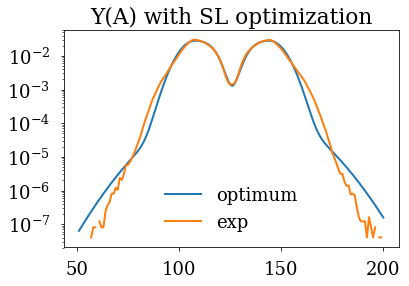

In [20]:
plt.semilogy(A,YA_sl(resultsl.x), label = 'optimum')
plt.semilogy(A,YA_data, label = 'exp')
plt.title('Y(A) with SL optimization')
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

In [21]:
print(result)
# for initial guesses of d values

      fun: 1032405.7957266469
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.45058060e+00,   3.14321369e-01,   2.51457095e+00,
        -2.34991079e+04,   2.37192726e+03,  -2.51425197e+04,
         4.17208765e+04,  -1.90554420e+04,   5.75501472e+03,
         9.51532624e+04,  -2.49944860e+03,   3.42646148e+04,
        -4.46826452e+03,  -4.06088307e+04,   3.88416927e+04,
        -1.53742498e+04,  -4.15706309e+04,   5.04560885e+04])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 722
      nit: 31
   status: 1
  success: False
        x: array([  2.02000000e+04,   1.47000000e+05,   8.70000000e+05,
         1.68222595e+01,   1.08928649e+01,   1.40695174e+01,
         1.88918116e+01,   1.72329367e+01,   1.82917516e+01,
         8.64536930e-01,   9.59530107e-02,   3.31185862e-01,
         1.26921719e+02,   1.35459943e+02,   1.43932846e+02,
         1.16938724e+01,   3.25757609e+00,   6.13119367e+00])


# Now we go on to fit to Y(TKE)

In [22]:
# now that overall result is done, we do some fine tuning, mode by mode

# for TKE, we will calculate Y(A, TKE) mode by mode and then project that into a 1d Y(TKE)
def YTKE_s2(tup_in):
    h2, dmin2, dmax2, ddec2 = tup_in
    hl, h1 = 2.02e4, 1.47e5
    dminl, dmin1 = 1.68207616e+01,   1.08929519e+01
    dmaxl, dmax1 = 1.88909129e+01,   1.72329207e+01
    ddecl, ddec1 = 8.62889639e-01,   9.59024307e-02
    Abarl, Abar1, Abar2 = 1.27530330e+02, 1.36328441e+02, 1.44542941e+02
    sigAl, sigA1, sigA2 = 1.82257350e+01, 3.69590546e+00, 6.11049848e+00

    A_cn = 252.
    
    YATKE_TKEs2 = YATKE((A,TKE), hl,h1,h2, dminl,dmin1,dmin2, dmaxl,dmax1,dmax2,
         ddecl,ddec1,ddec2, Abarl,Abar1,Abar2, sigAl,sigA1,sigA2)
    YTKE = YTKEproj(rearrange(YATKE_TKEs2))
        
    # normalize to pdf 
    total = sum(YTKE)
    YTKE = np.asarray([float(i)/total for i in YTKE])
    
    return YTKE

YATKE_data   = get_all_data()
YTKE_data    = YTKEproj(rearrange(YATKE_data))
def chi2YTKEs2(tup_in):

    YTKE_model     = YTKE_s2(tup_in)
    return  chi2(YTKE_model[YTKE_data != 0.], YTKE_data[YTKE_data != 0.])

res_ovrll = result.x
s2gTKE = np.array([res_ovrll[2], res_ovrll[5], res_ovrll[8], res_ovrll[11]])
print(s2gTKE)
bnds = ((0.,None),(0.,None), (0.,None), (0.,None))
results2TKE =  opt.minimize(chi2YTKEs2, s2gTKE, bounds=bnds, options={'disp': True})
print(results2TKE)

DATA ACQUIRED
[  8.70000000e+05   1.40695174e+01   1.82917516e+01   3.31185862e-01]
      fun: 0.0028149265336167586
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.73472348e-09,  -1.19695920e-08,  -4.93398725e-07,
         2.34881559e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 14
   status: 0
  success: True
        x: array([  8.70000000e+05,   1.44946840e+01,   1.82042691e+01,
         4.46051524e-01])


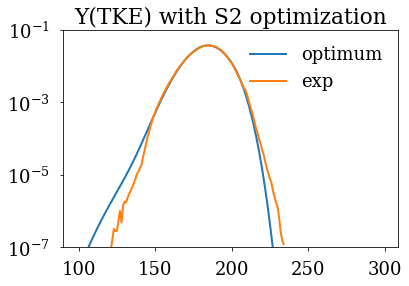

In [23]:
plt.semilogy(TKE,YTKE_s2(results2TKE.x), label = 'optimum')
plt.semilogy(TKE,YTKE_data, label = 'exp')
plt.title('Y(TKE) with S2 optimization')
plt.ylim(1e-7, 1e-1)
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

In [24]:
# now that overall result is done, we do some fine tuning, mode by mode

# for TKE, we will calculate Y(A, TKE) mode by mode and then project that into a 1d Y(TKE)
def YTKE_s1(tup_in):
    h1, dmin1, dmax1, ddec1 = tup_in
    hl, h2 = 2.02e4, 8.70000000e+05
    dminl, dmin2 = 1.68207616e+01,   1.44946848e+01
    dmaxl, dmax2 = 1.88909129e+01,   1.82042691e+01
    ddecl, ddec2 = 8.62889639e-01,   4.46051597e-01
    Abarl, Abar1, Abar2 = 1.27530330e+02, 1.36328441e+02, 1.44542941e+02
    sigAl, sigA1, sigA2 = 1.82257350e+01, 3.69590546e+00, 6.11049848e+00

    A_cn = 252.
    
    YATKE_TKEs1 = YATKE((A,TKE), hl,h1,h2, dminl,dmin1,dmin2, dmaxl,dmax1,dmax2,
         ddecl,ddec1,ddec2, Abarl,Abar1,Abar2, sigAl,sigA1,sigA2)
    YTKE = YTKEproj(rearrange(YATKE_TKEs1))
        
    # normalize to pdf 
    total = sum(YTKE)
    YTKE = np.asarray([float(i)/total for i in YTKE])
    
    return YTKE

YATKE_data   = get_all_data()
YTKE_data    = YTKEproj(rearrange(YATKE_data))
def chi2YTKEs1(tup_in):

    YTKE_model     = YTKE_s1(tup_in)
    return  chi2(YTKE_model[YTKE_data != 0.], YTKE_data[YTKE_data != 0.])

res_ovrll = result.x
s1gTKE = np.array([res_ovrll[1], res_ovrll[4], res_ovrll[7], res_ovrll[10]])
print(s1gTKE)
bnds = ((0.,None),(0.,None), (0.,None), (0.,None))
results1TKE =  opt.minimize(chi2YTKEs1, s1gTKE, bounds=bnds, options={'disp': True})
print(results1TKE)

DATA ACQUIRED
[  1.47000000e+05   1.08928649e+01   1.72329367e+01   9.59530107e-02]
      fun: 0.0020041358855561985
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.51028104e-09,   1.16030449e-05,  -3.53883589e-08,
        -3.76651835e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 10
   status: 0
  success: True
        x: array([  1.47000000e+05,   1.08923622e+01,   1.73227450e+01,
         1.34701099e-01])


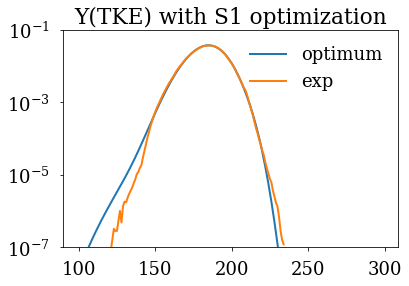

In [25]:
plt.semilogy(TKE,YTKE_s1(results1TKE.x), label = 'optimum')
plt.semilogy(TKE,YTKE_data, label = 'exp')
plt.title('Y(TKE) with S1 optimization')
plt.ylim(1e-7, 1e-1)
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

In [26]:
# now that overall result is done, we do some fine tuning, mode by mode

# for TKE, we will calculate Y(A, TKE) mode by mode and then project that into a 1d Y(TKE)
def YTKE_sl(tup_in):
    hl, dminl, dmaxl, ddecl = tup_in
    h1, h2 = 1.47000000e+05, 8.70000000e+05
    dmin1, dmin2 = 1.08924571e+01,   1.44946848e+01
    dmax1, dmax2 = 1.73227450e+01,   1.82042691e+01
    ddec1, ddec2 = 1.34703577e-01,   4.46051597e-01
    Abarl, Abar1, Abar2 = 1.27530330e+02, 1.36328441e+02, 1.44542941e+02
    sigAl, sigA1, sigA2 = 1.82257350e+01, 3.69590546e+00, 6.11049848e+00

    A_cn = 252.
    
    YATKE_TKEsl = YATKE((A,TKE), hl,h1,h2, dminl,dmin1,dmin2, dmaxl,dmax1,dmax2,
         ddecl,ddec1,ddec2, Abarl,Abar1,Abar2, sigAl,sigA1,sigA2)
    YTKE = YTKEproj(rearrange(YATKE_TKEsl))
        
    # normalize to pdf 
    total = sum(YTKE)
    YTKE = np.asarray([float(i)/total for i in YTKE])
    
    return YTKE

YATKE_data   = get_all_data()
YTKE_data    = YTKEproj(rearrange(YATKE_data))
def chi2YTKEsl(tup_in):

    YTKE_model     = YTKE_sl(tup_in)
    return  chi2(YTKE_model[YTKE_data != 0.], YTKE_data[YTKE_data != 0.])

res_ovrll = result.x
slgTKE = np.array([res_ovrll[0], res_ovrll[3], res_ovrll[6], res_ovrll[9]])
print(slgTKE)
bnds = ((0.,None),(0.,None), (0.,None), (1e-9,None))
resultslTKE =  opt.minimize(chi2YTKEsl, slgTKE, bounds=bnds, options={'disp': True})
print(resultslTKE)

DATA ACQUIRED
[  2.02000000e+04   1.68222595e+01   1.88918116e+01   8.64536930e-01]
      fun: 0.00075231590180236329
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.30104261e-10,   2.87673531e-06,  -1.76361746e-06,
        -6.80014855e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 80
      nit: 14
   status: 0
  success: True
        x: array([  2.02000000e+04,   1.67167869e+01,   2.04273043e+01,
         1.65727013e-01])


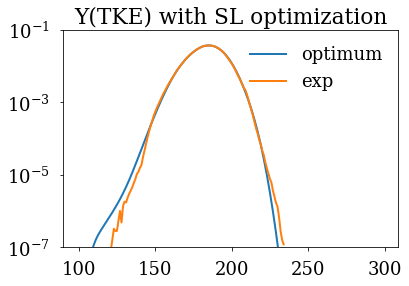

In [27]:
plt.semilogy(TKE,YTKE_sl(resultslTKE.x), label = 'optimum')
plt.semilogy(TKE,YTKE_data, label = 'exp')
plt.title('Y(TKE) with SL optimization')
plt.ylim(1e-7, 1e-1)
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

# Now we will fit the contribution values to minimize h

In [28]:
# now that overall result is done, we do some fine tuning, mode by mode

# for TKE, we will calculate Y(A, TKE) mode by mode and then project that into a 1d Y(TKE)
def YATKE_h(tup_in):
    hl, h1, h2 = tup_in
    dminl, dmin1, dmin2 = 1.67133975e+01, 1.08924571e+01,   1.44946848e+01
    dmaxl, dmax1, dmax2 = 2.04274353e+01, 1.73227450e+01,   1.82042691e+01
    ddecl, ddec1, ddec2 = 1.65676002e-01, 1.34703577e-01,   4.46051597e-01
    Abarl, Abar1, Abar2 = 1.27530330e+02, 1.36328441e+02, 1.44542941e+02
    sigAl, sigA1, sigA2 = 1.82257350e+01, 3.69590546e+00, 6.11049848e+00

    A_cn = 252.
    
    YATKE_h = YATKE((A,TKE), hl,h1,h2, dminl,dmin1,dmin2, dmaxl,dmax1,dmax2,
         ddecl,ddec1,ddec2, Abarl,Abar1,Abar2, sigAl,sigA1,sigA2)
    
    return YATKE_h

YATKE_data   = get_all_data()

def chi2YATKEh(tup_in):

    YATKE_model     = YATKE_h(tup_in)
    return  chi2(YATKE_model[YATKE_data != 0.], YATKE_data[YATKE_data != 0.])

res_ovrll = result.x
shg = np.array([res_ovrll[0], res_ovrll[1], res_ovrll[2]])
print(shg)
bnds = ((0.,None),(0.,None), (0.,None))
resultYATKEh =  opt.minimize(chi2YATKEh, shg, bounds=bnds, options={'disp': True})
print(resultYATKEh)

DATA ACQUIRED
[  20199.99996909  146999.99998653  869999.99998312]
      fun: 1465453.4671808439
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.13969839,  0.37252903,  0.27939677])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 268
      nit: 15
   status: 0
  success: True
        x: array([  12303.67185349,  155112.69151267,  727073.51105839])


DATA ACQUIRED


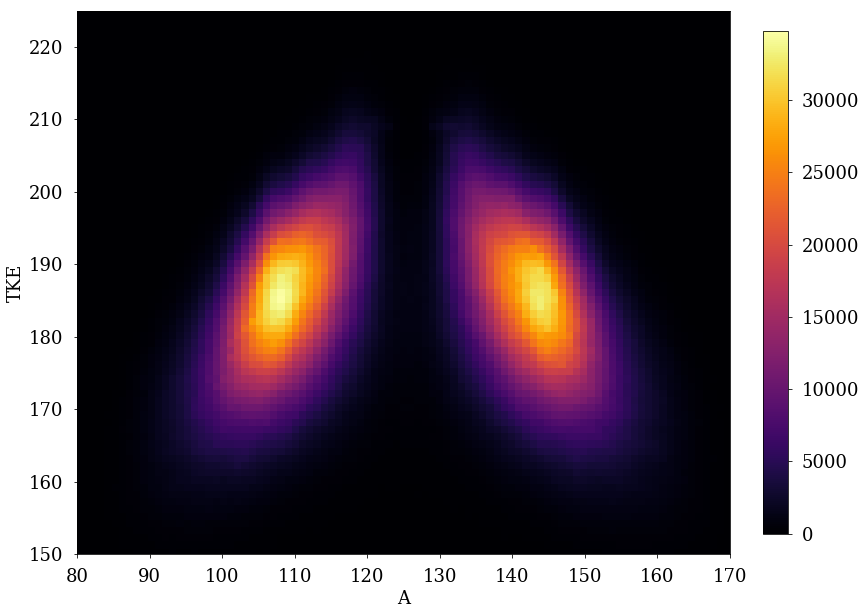

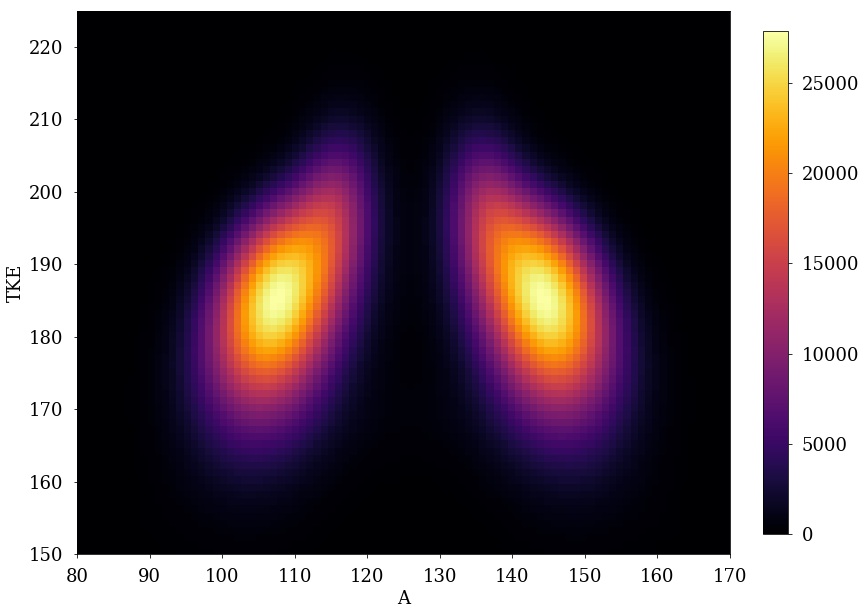

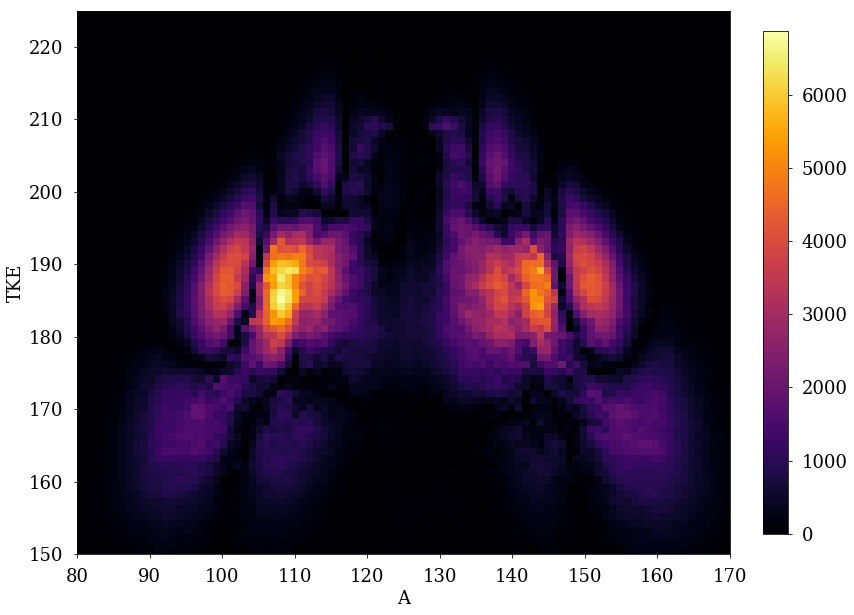

In [29]:
# plot of the residuals
# relative residuals
YATKE_data = get_all_data()
YATKE_fit  = YATKE_h(resultYATKEh.x)
YATKEres = np.zeros(len(YATKE_data))
for i in range(len(YATKE_data)):
    if YATKE_data[i] > 0.0:
        YATKEres[i] = np.abs(YATKE_data[i] - YATKE_fit[i]) 

YATKEplot(rearrange(YATKE_data)) 
YATKEplot(rearrange(YATKE_fit))     
YATKEplot(rearrange(YATKEres))


In [30]:
print(resultsl.x[0])

20200.0086472


(1e-07, 0.1)

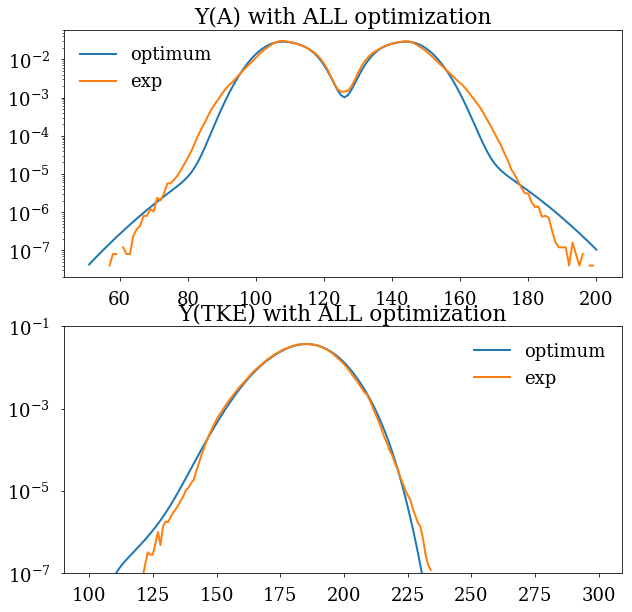

In [39]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.semilogy(A,YAproj(rearrange(YATKE_h(resultYATKEh.x))), label = 'optimum')
plt.semilogy(A,YA_data, label = 'exp')
plt.title('Y(A) with ALL optimization')
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)

plt.subplot(2,1,2)
plt.semilogy(TKE,YTKEproj(rearrange(YATKE_h(resultYATKEh.x))), label = 'optimum')
plt.semilogy(TKE,YTKE_data, label = 'exp')
plt.title('Y(TKE) with ALL optimization')
lg = plt.legend(numpoints=1,fontsize=18, loc='best')
lg.draw_frame(False)
plt.ylim(1e-7, 1e-1)